## Data Loading
First leg of the journey (10,000 points)

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
import itertools

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
telemetry = pd.read_csv('./telemetry_cleaned.csv')

X = telemetry[['Easting', 'Northing', 'WaterDepth']].head(10000) # 10,000
# X = telemetry.head(10619) # 10,000
# X = X[X['WaterDepth'] >= 30]
# X = X[X['WaterDepth'] <= 65]

In [3]:
X.head(5)

,Easting,Northing,WaterDepth
0,0.158187,0.410159,92.93
1,0.158187,0.410159,5.86
2,0.534407,0.535898,5.86
3,0.534311,0.535924,6.33
4,0.533734,0.536254,7.02


### Helpers

In [5]:
def num_of_clusters(db):
	return len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

def plot2d(data):
	data.plot(kind='scatter', x='Easting', y='Northing', color='#1F77B4')

def plot3d(data, title):
	fig = plt.figure()
	ax = fig.add_subplot(projection='3d')
	ax.scatter(data['Easting'], data['Northing'], data['WaterDepth'])
	ax.set_xlabel('Easting')
	ax.set_ylabel('Northing')
	ax.set_label
	ax.set_zlabel('WaterDepth')
	ax.set_title(title)
	plt.show()

def plot_clusters(db, show_noise=True):
	unique_labels = set(db.labels_)
	core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
	core_samples_mask[db.core_sample_indices_] = True

	colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

	for k, color in zip(unique_labels, colors):
		if k == -1 and not show_noise:
			# Black used for noise
			color = [0, 0, 0, 1]
			continue

		class_member_mask = db.labels_ == k

		core_samples = X[class_member_mask & core_samples_mask]

		plt.plot(
			core_samples['Easting'],
			core_samples['Northing'],
			"o",
			markerfacecolor=tuple(color),
			markeredgecolor='k',
			markersize=10,
		)

		non_core_samples = X[class_member_mask & ~core_samples_mask]
		plt.plot(
			non_core_samples['Easting'],
			non_core_samples['Northing'],
			"o",
			markerfacecolor=tuple(color),
			markeredgecolor='k',
			markersize=3,
		)

	plt.title(f'Estimated clusters: {len(unique_labels)-1}')
	plt.show()

### Base Plots

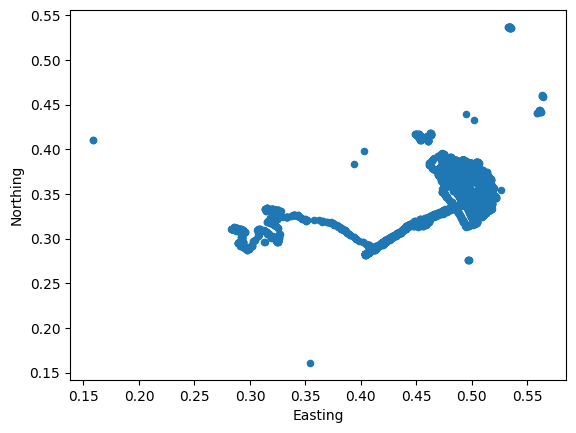

In [6]:
plot2d(X)

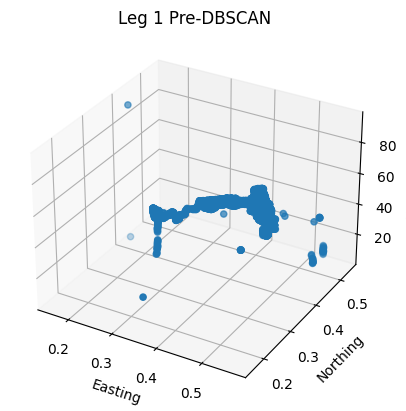

In [7]:
plot3d(X, 'Leg 1 Pre-DBSCAN')

## DBSCAN Clustering

Calculating epsilon value

$
\epsilon=|\lambda_{avg} - \varphi_{avg} - \rho_{avg}|
$

In [8]:
def avg(col):
	return sum(col) / len(col)

epsilon = abs(1 - (telemetry['Easting']) - (telemetry['Northing']) - (telemetry['WaterDepth']))
epsilon = round(epsilon, 4)
epsilon

0         92.4983
1          5.4283
2          5.9303
3          6.4002
4          7.0900
           ...   
332733     0.8188
332734     0.8486
332735     0.7984
332736     0.7982
332737     0.7482
Length: 332738, dtype: float64

Baseline result

In [46]:
db = DBSCAN(eps=0.0, min_samples=5).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

Estimated number of clusters: 32
Estimated number of noise points: 84


Performing grid search

In [35]:
def grid_search_dbscan(data, options, verbose=False):
	results = []

	# Iterate through all combinations of options
	# And perform a DBSCAN evaluation on each
	option_combs = itertools.product(*options.values())

	for eps, min_samples in list(option_combs):
		if verbose: print(f'Running eps={eps}, min_samples={min_samples}')

		db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
		labels = db.labels_

		# Get estimated number of clusters and noise points
		clusters = num_of_clusters(db)
		noise = list(labels).count(-1)

		# Silhouette Coefficient
		silhouette = metrics.silhouette_score(X, labels)

		# Davies-Bouldin Score
		davies_bouldin = metrics.davies_bouldin_score(X, labels)

		if verbose: print(f'Finished with silhouette={silhouette}, davies={davies_bouldin}')

		results.append({
			'eps': eps,
			'min_samples': min_samples,
			'clusters': clusters,
			'noise': noise,
			'silhouette': silhouette,
			'davies_bouldin': davies_bouldin
		})

	return pd.DataFrame(results)

In [36]:
# Run grid search with the following options
options = {
	"eps": [epsilon/10],
	"min_samples": range(5,16)
}

results = grid_search_dbscan(X, options, True)

Running eps=0.04018, min_samples=5
Finished with silhouette=0.2549448774558935, davies=1.2826740102728094
Running eps=0.04018, min_samples=6
Finished with silhouette=0.3328376246224976, davies=1.312410526161564
Running eps=0.04018, min_samples=7
Finished with silhouette=0.3320630447457233, davies=2.2471967193214835
Running eps=0.04018, min_samples=8
Finished with silhouette=0.3320630447457233, davies=2.2471967193214835
Running eps=0.04018, min_samples=9
Finished with silhouette=0.3320630447457233, davies=2.2471967193214835
Running eps=0.04018, min_samples=10
Finished with silhouette=0.3320630447457233, davies=2.2471967193214835
Running eps=0.04018, min_samples=11
Finished with silhouette=0.3320630447457233, davies=2.2471967193214835
Running eps=0.04018, min_samples=12
Finished with silhouette=0.331289498067839, davies=1.7967669907926613
Running eps=0.04018, min_samples=13
Finished with silhouette=0.32999770294080255, davies=1.19631946624188
Running eps=0.04018, min_samples=14
Finished 

In [18]:
results

,eps,min_samples,clusters,noise,silhouette,davies_bouldin
0,0.01457,5,8,13,0.241470,1.303106
1,0.01457,6,6,23,0.318237,1.801558
2,0.01457,7,6,23,0.318237,1.801558
3,0.01457,8,6,24,0.318076,1.844863
4,0.01457,9,6,29,0.321065,1.545850
5,0.01457,10,6,40,0.518035,1.241466
6,0.01457,11,4,70,0.514670,1.180388
7,0.01457,12,4,70,0.514670,1.180388
8,0.01457,13,5,73,0.465143,1.192704
9,0.01457,14,4,88,0.513638,1.338068


Row with best silhouette score

In [28]:
results.sort_values(by='silhouette', ascending=False, ignore_index=True).head(5)

,eps,min_samples,clusters,noise,silhouette,davies_bouldin
0,0.004515,13,25,437,0.453992,1.251732
1,0.004515,11,27,341,0.431241,1.327285
2,0.004515,12,26,399,0.404171,1.273220
3,0.004515,14,26,475,0.392650,1.238315
4,0.045150,6,6,10,0.334693,1.193807


Row with best davies-bouldin score

In [27]:
results.sort_values(by='davies_bouldin', ascending=True, ignore_index=True).head(5)

,eps,min_samples,clusters,noise,silhouette,davies_bouldin
0,0.045150,5,7,5,0.255997,1.059589
1,0.045150,6,6,10,0.334693,1.193807
2,0.004515,6,27,166,0.164764,1.196316
3,0.004515,5,30,121,0.210288,1.197173
4,0.045150,14,3,39,0.331942,1.197308


(-0.1, 1.0)

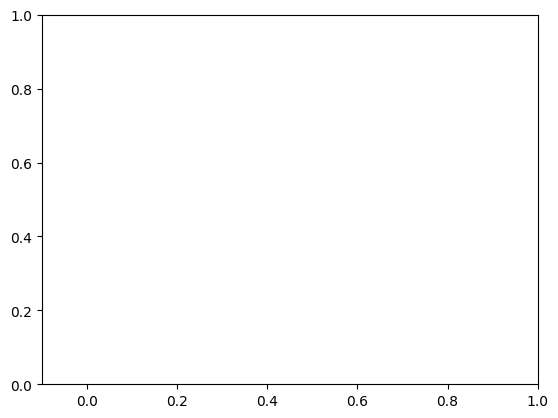

In [79]:
fig, ax = plt.subplots(1)

ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
cluster_labels = clusterer.fit_predict(X)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print(
		"For n_clusters =",
		n_clusters,
		"The average silhouette_score is :",
		silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
		# Aggregate the silhouette scores for samples belonging to
		# cluster i, and sort them
		ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

		ith_cluster_silhouette_values.sort()

		size_cluster_i = ith_cluster_silhouette_values.shape[0]
		y_upper = y_lower + size_cluster_i

		color = cm.nipy_spectral(float(i) / n_clusters)
		ax1.fill_betweenx(
				np.arange(y_lower, y_upper),
				0,
				ith_cluster_silhouette_values,
				facecolor=color,
				edgecolor=color,
				alpha=0.7,
		)

		# Label the silhouette plots with their cluster numbers at the middle
		ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

		# Compute the new y_lower for next plot
		y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

## Cluster Evaluation Metrics

### Silhouette Coefficient
The silhouette coefficient measures the quality of the model by the distance significance between clusters.

It uses the following formula:
$$s = \frac{b-a}{\max{(a,b)}}$$

Where $a$ is the mean distance between a sample and all other points within the *same* cluster, and $b$ is the mean distance between a sample and all other points in the *next nearest* cluster. It outputs a score in the range of -1 to 1, where -1 indicated incorrect clustering and 1 indicates highly dense clustering. A score of 0 indicates an overlap in clusters.

Source: Adapted from [Quick Guide to Evaluation Metrics for Supervised and Unsupervised Machine Learning](https://www.analyticsvidhya.com/blog/2020/10/quick-guide-to-evaluation-metrics-for-supervised-and-unsupervised-machine-learning/) § Clustering Performance Evaluation Metrics

### Implementation
Scikit learn provides a silhouette_score method in its metrics module:

In [35]:
print(f'Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}')

Silhouette Coefficient: 0.463


### Davies-Bouldin Score


In [36]:
print(f'Davies-Bouldin Score: {metrics.davies_bouldin_score(X, labels):.3f}')

Davies-Bouldin Score: 5.994


## Removing Clusters
First, let's map the labels to each row in the dataset.

In [37]:
X['label'] = labels
X.head(5)

,Easting,Northing,WaterDepth,label
0,0.158187,0.410159,0.619607,-1
1,0.158187,0.410159,0.038946,-1
2,0.534407,0.535898,0.038946,-1
3,0.534311,0.535924,0.042081,-1
4,0.533734,0.536254,0.046682,-1


Then we can remove the rows labeled as noise, denoted by a value of -1.

In [38]:
denoised = X[X['label'] != -1]
denoised['label'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

Clusters (with noise)

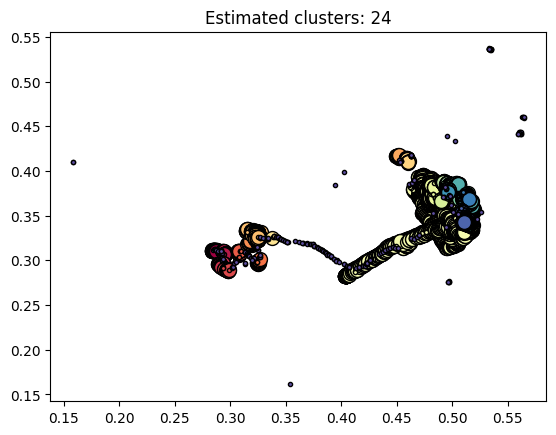

In [39]:
plot_clusters(db)

Clusters (without noise)

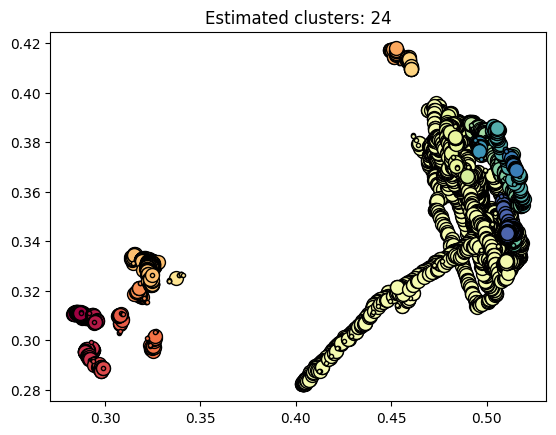

In [40]:
plot_clusters(db, False)